<h2><center>The Experiments for Margin on Cifar10</center></h2>

In [1]:
# -*- coding: utf-8 -*-
__author__ = 'huangyf'

import os
import re
import sys
import pickle
import torch
import time
from PIL import Image
import seaborn as sbn
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import scipy.stats
from torch import nn, optim
import torch.nn.functional as F
from data_loader import get_loader
from torchvision import transforms
from models import basic_cnn
from utils import AverageMeter, accuracy, get_margin, ramp_loss, margin_error

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

use_gpu = torch.cuda.is_available()


def train_model(model, criterion, optimizer, log_saver, g0, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'train1', 'test']:

            margin = []
            loss_meter = AverageMeter()
            rloss_meter = AverageMeter()
            ramp_loss_meter = AverageMeter()
            acc_meter = AverageMeter()
            margin_error_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[re.findall('[a-zA-Z]+',
                                                        phase)[0]]):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1

                N = outputs.size(0)

                margin = np.append(margin, get_margin(outputs, labels))
                loss_meter.update(loss.data.item(), N)
                acc_meter.update(
                    accuracy(outputs.data, labels.data)[-1].item(), N)

                if phase != 'train':
                    gamma = log_saver['Lip'][-1] * g0
                    ramp_loss_meter.update(
                        ramp_loss(get_margin(outputs, labels), gamma), N)
                    rloss_meter.update(
                        criterion(outputs / log_saver['Lip'][-1],
                                  labels).data.item(), N)
                    margin_error_meter.update(
                        margin_error(get_margin(outputs, labels), gamma), N)

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':
                log_saver['model_state'].append(model.state_dict())
                model.eval()
                lip = 1
                for i in range(6):
                    if i <= 4:
                        size = eval('model.features.conv%d.weight.size()' % i)
                        # here to compute the l1 norm between each CNN layer
                        w_cnn = eval(
                            'model.features.conv%d.weight.view(size[0],size[1],-1)' %
                            i)
                        w_bn = eval('model.features.bn%d.weight' % i)
                        var_bn = eval('model.features.bn%d.running_var' % i)
                        eps_bn = eval('model.features.bn%d.eps' % i)
                        scale = w_bn / (var_bn.sqrt() + eps_bn)
                        w_cnn_new = w_cnn * scale.view(-1, 1,1)

                        # sqrt of l1 norm
                        w_norm=(w_cnn_new.norm(p=1,dim=2).max()*w_cnn_new.norm(1)).sqrt().data.item()
                        log_saver['w%d' % i].append(w_norm)
                    else:
                        w_norm = model.classifier.weight.norm(2).data.item()
                        log_saver['w_fc'].append(w_norm)
                    lip *= w_norm / 1000
                log_saver['Lip'].append(lip)

            if phase == 'train1':

                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)
                log_saver['margin_train'].append(margin)
                log_saver['train_rloss'].append(rloss_meter.avg)
                log_saver['train_ramp_loss'].append(ramp_loss_meter.avg)
                log_saver['train_margin_error'].append(margin_error_meter.avg)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)
                log_saver['margin_test'].append(margin)
                log_saver['test_rloss'].append(rloss_meter.avg)
                log_saver['test_ramp_loss'].append(ramp_loss_meter.avg)
                log_saver['test_margin_error'].append(margin_error_meter.avg)

            if phase != 'train':
                print(
                    f'{phase} Loss: {epoch_loss:.4f} rLoss: {rloss_meter.avg:.4f} Error: {epoch_error:.4f}',
                    f'RampLoss: {ramp_loss_meter.avg:.6f} MarginError: {margin_error_meter.avg:.4f}',
                    f"Margin: {min(margin):.4f} Lip: {log_saver['Lip'][-1]:.4e}"
                )

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {'net': model, 'epoch': epoch, 'log': log_saver}

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state,
                       './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )

    return model, log_saver

/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Original Cifar10

## cnn50

In [2]:
# %%
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'
g0 = 20

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log = {
    'num_params': [],
    'model_state':[],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'w0': [],
    'w1': [],
    'w2': [],
    'w3': [],
    'w4': [],
    'w_fc': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
channels = 50
# here use with_bn to control batch normalisation
model = basic_cnn.CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: original ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 92610


In [3]:
model, log = train_model(
    model, criterion, optimizer, log, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 1.6953 rLoss: 1952249681.2800 Error: 0.5679 RampLoss: 0.567880 MarginError: 0.5679 Margin: -4.2727 Lip: 1.7061e-10
test Loss: 1.7056 rLoss: 1988239573.7600 Error: 0.5784 RampLoss: 0.578400 MarginError: 0.5784 Margin: -3.8698 Lip: 1.7061e-10
Saving..
Epoch 2/100
----------
train1 Loss: 1.4217 rLoss: 2179150401.0240 Error: 0.4964 RampLoss: 0.496400 MarginError: 0.4964 Margin: -5.8801 Lip: 2.0044e-10
test Loss: 1.4476 rLoss: 2284849009.9200 Error: 0.5091 RampLoss: 0.509100 MarginError: 0.5091 Margin: -6.5317 Lip: 2.0044e-10
Epoch 3/100
----------
train1 Loss: 1.2974 rLoss: 1671856161.2800 Error: 0.4515 RampLoss: 0.451520 MarginError: 0.4515 Margin: -6.5225 Lip: 2.4627e-10
test Loss: 1.3337 rLoss: 1780458894.0800 Error: 0.4646 RampLoss: 0.464600 MarginError: 0.4646 Margin: -5.8046 Lip: 2.4627e-10
Epoch 4/100
----------
train1 Loss: 1.1491 rLoss: 1525996259.5840 Error: 0.4080 RampLoss: 0.408040 MarginError: 0.4080 Margin: -7.4860 Lip: 2.8057e-10
test Loss

In [4]:
import pickle
pickle.dump(log,open('./results_original/log_original_50_with_state.log','wb'))

In [67]:
import pickle
log=pickle.load(open('./results_original/log_original_50_with_state.log','rb'))

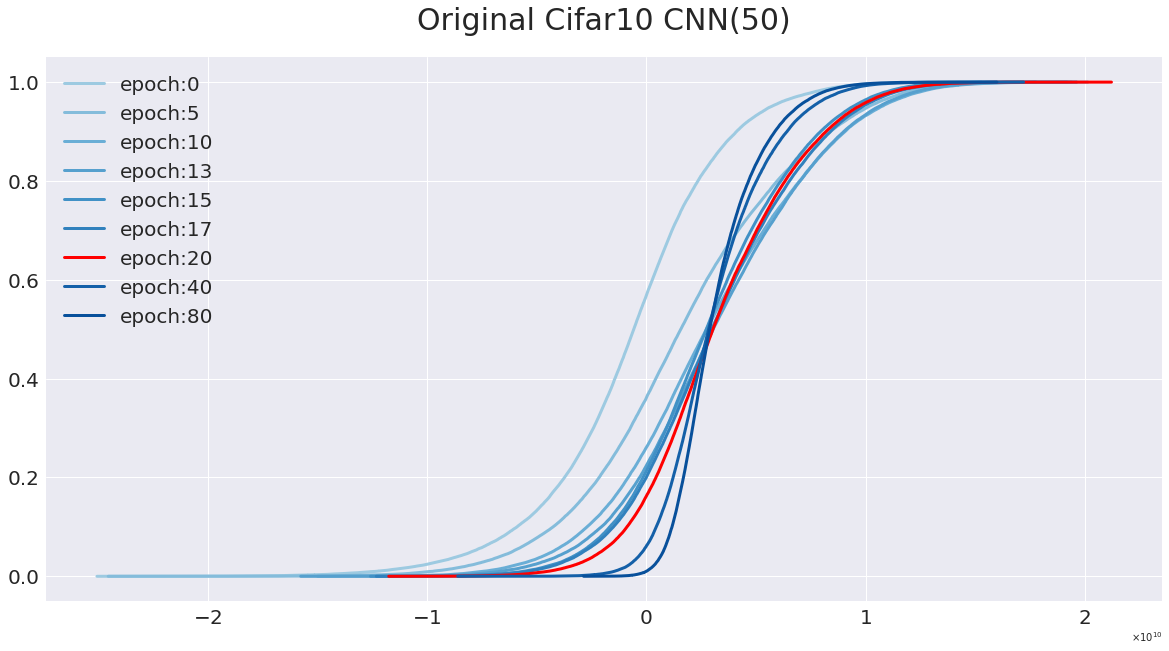

In [68]:
channel=50
interval=[-1,1]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('Original Cifar10 CNN(50)', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0,5, 10,13,15,17,20, 40, 80]):
    c=sbn.color_palette('Blues',15)[j+5]
    if i==20:
        c='r'
    ax.plot(np.sort(log['margin_train'][i])/log['Lip'][i], np.arange(50000)/50000,label=f'epoch:{i}',c=c,linewidth=3)
#ax.set_xlim(interval)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
ax.legend(fontsize=20)
fig.savefig('./results_original/(re)train_nMargin_distribution_50.png')
plt.show()

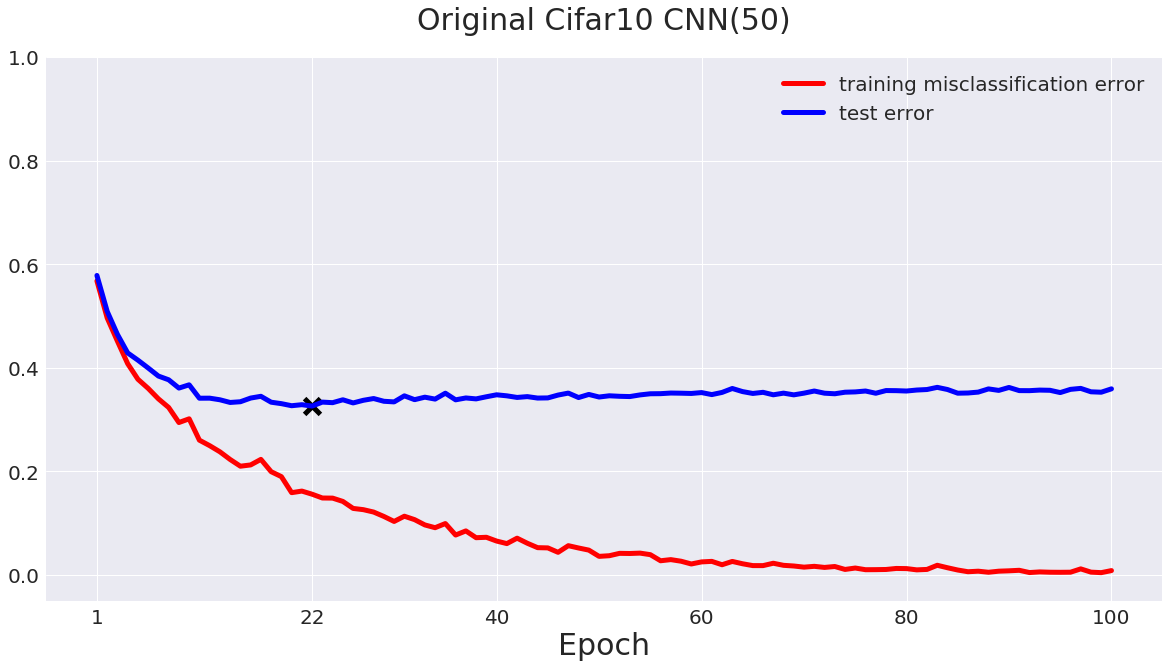

In [29]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Original Cifar10 CNN(50)',fontsize=30, y=1.04)

ax.plot(log['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
x1=np.argmin(log['test_error'])
ax.scatter(x1,log['test_error'][x1],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
ax.set_xticks([0,x1,39,59,79,99])
ax.set_xticklabels([1,x1+1,40,60,80,100])
ax.legend(loc='best',fontsize=20)
fig.savefig('./results_original/(re)train_and_test_error_50.png')

plt.show()

## cnn400

In [5]:
# %%
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'
g0 = 20

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log = {
    'num_params': [],
    'model_state':[],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'w0': [],
    'w1': [],
    'w2': [],
    'w3': [],
    'w4': [],
    'w_fc': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
channels = 400
# here use with_bn to control batch normalisation
model = basic_cnn.CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: original ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 5780810


In [6]:
model, log = train_model(
    model, criterion, optimizer, log, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 1.1543 rLoss: 6645410.3175 Error: 0.4024 RampLoss: 0.402360 MarginError: 0.4024 Margin: -7.0928 Lip: 5.9988e-08
test Loss: 1.2218 rLoss: 7553553.2700 Error: 0.4305 RampLoss: 0.430500 MarginError: 0.4305 Margin: -6.6086 Lip: 5.9988e-08
Saving..
Epoch 2/100
----------
train1 Loss: 0.9284 rLoss: 5859701.0325 Error: 0.3204 RampLoss: 0.320440 MarginError: 0.3204 Margin: -6.9001 Lip: 6.3313e-08
test Loss: 1.0681 rLoss: 7688770.9750 Error: 0.3866 RampLoss: 0.386600 MarginError: 0.3866 Margin: -8.3718 Lip: 6.3313e-08
Epoch 3/100
----------
train1 Loss: 0.7111 rLoss: 3556671.5482 Error: 0.2399 RampLoss: 0.239940 MarginError: 0.2399 Margin: -7.4241 Lip: 8.0526e-08
test Loss: 0.9636 rLoss: 6211486.1125 Error: 0.3405 RampLoss: 0.340500 MarginError: 0.3405 Margin: -9.5990 Lip: 8.0526e-08
Epoch 4/100
----------
train1 Loss: 0.5209 rLoss: 1980618.7390 Error: 0.1630 RampLoss: 0.163000 MarginError: 0.1630 Margin: -9.5023 Lip: 9.0332e-08
test Loss: 0.8986 rLoss: 54364

In [7]:
import pickle
pickle.dump(log,open('./results_original/log_original_400_with_state.log','wb'))

In [65]:
import pickle
log=pickle.load(open('./results_original/log_original_400_with_state.log','rb'))

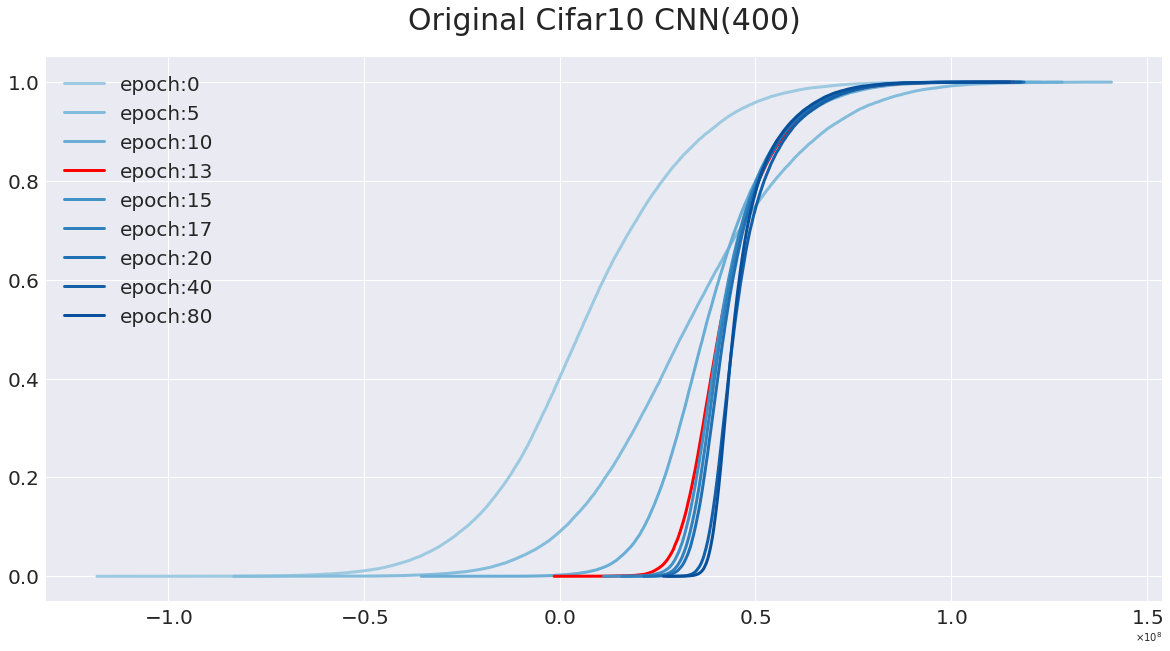

In [66]:
import seaborn as sbn
interval=[-1,1]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('Original Cifar10 CNN(400)', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0,5, 10,13,15,17,20, 40, 80]):
    c=sbn.color_palette('Blues',15)[j+5]
    if i==13:
        c='r'
    ax.plot(np.sort(log['margin_train'][i])/log['Lip'][i], np.arange(50000)/50000,label=f'epoch:{i}',c=c,linewidth=3)
#ax.set_xlim(interval)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
ax.legend(fontsize=20)
fig.savefig('./results_original/(re)train_nMargin_distribution_400.png')
plt.show()

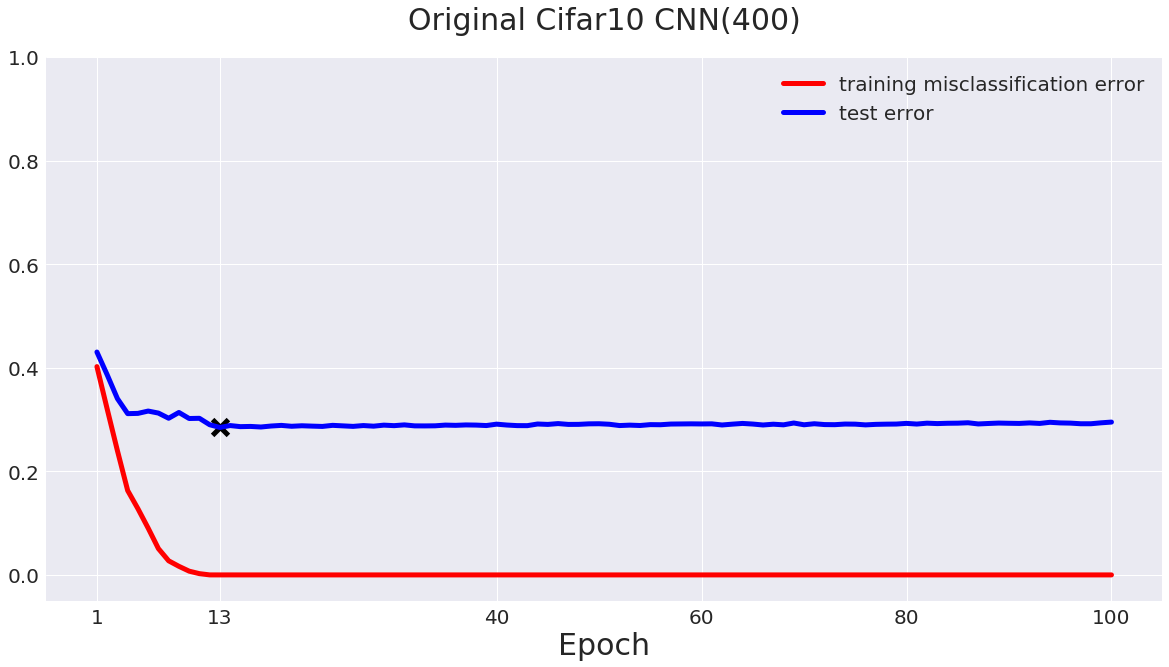

In [34]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Original Cifar10 CNN(400)',fontsize=30, y=1.04)

ax.plot(log['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
x1=np.argmin(log['test_error'])
ax.scatter(x1,log['test_error'][x1],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
ax.set_xticks([0,x1,39,59,79,99])
ax.set_xticklabels([1,x1+1,40,60,80,100])
ax.legend(loc='best',fontsize=20)
fig.savefig('./results_original/(re)train_and_test_error_400.png')

plt.show()

# Cifar10 with 0.1 noise

## CNN50

In [8]:
# %%
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 20

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log_1 = {
    'num_params': [],
    'model_state':[],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'w0': [],
    'w1': [],
    'w2': [],
    'w3': [],
    'w4': [],
    'w_fc': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
channels = 50
# here use with_bn to control batch normalisation
model = basic_cnn.CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_1['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 92610


In [9]:
model, log_1 = train_model(
    model, criterion, optimizer, log_1, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 1.8611 rLoss: 1561340056.8320 Error: 0.6299 RampLoss: 0.629920 MarginError: 0.6299 Margin: -8.5708 Lip: 2.4152e-10
test Loss: 1.8736 rLoss: 1573251359.3600 Error: 0.6298 RampLoss: 0.629800 MarginError: 0.6298 Margin: -7.2152 Lip: 2.4152e-10
Saving..
Epoch 2/100
----------
train1 Loss: 1.6684 rLoss: 1732209554.1760 Error: 0.5590 RampLoss: 0.558960 MarginError: 0.5590 Margin: -6.8947 Lip: 2.6414e-10
test Loss: 1.6910 rLoss: 1791170502.4000 Error: 0.5677 RampLoss: 0.567700 MarginError: 0.5677 Margin: -7.7040 Lip: 2.6414e-10
Epoch 3/100
----------
train1 Loss: 1.5300 rLoss: 1951212162.3040 Error: 0.5121 RampLoss: 0.512100 MarginError: 0.5121 Margin: -7.2360 Lip: 2.7729e-10
test Loss: 1.5642 rLoss: 2049343752.9600 Error: 0.5275 RampLoss: 0.527500 MarginError: 0.5275 Margin: -7.6393 Lip: 2.7729e-10
Epoch 4/100
----------
train1 Loss: 1.4559 rLoss: 1755593153.5360 Error: 0.4780 RampLoss: 0.477980 MarginError: 0.4780 Margin: -7.5669 Lip: 3.1153e-10
test Loss

In [10]:
import pickle
pickle.dump(log_1,open('./results_p0.1/log_p0.1_50_with_state.log','wb'))

In [63]:
import pickle
log_1=pickle.load(open('./results_p0.1/log_p0.1_50_with_state.log','rb'))

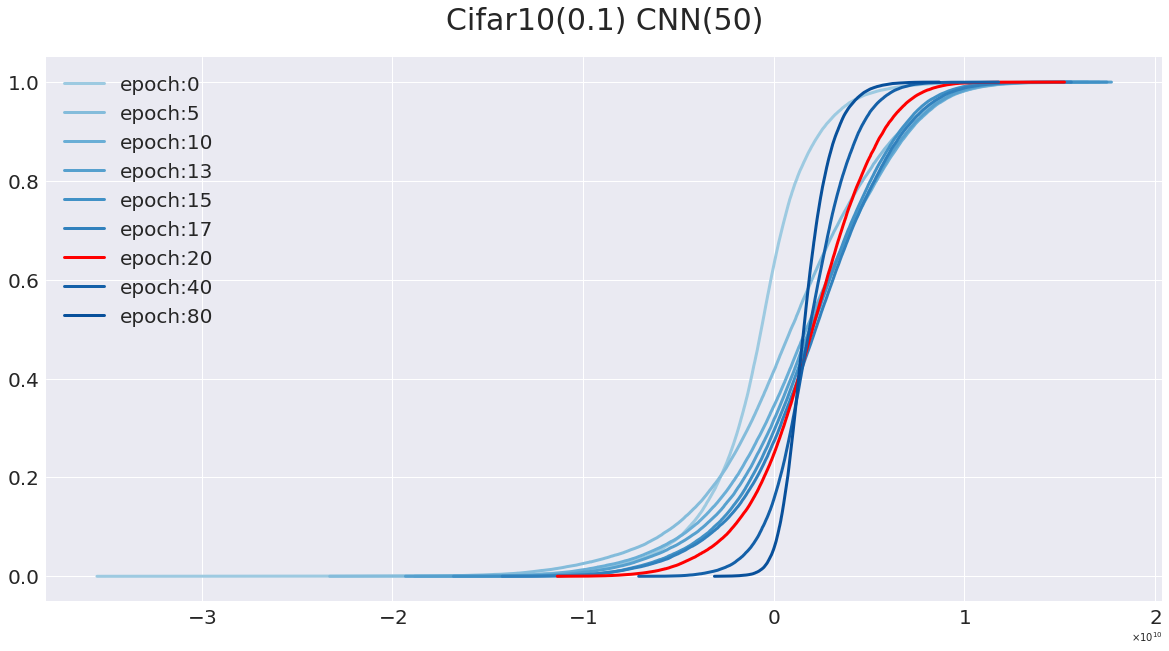

In [64]:
import seaborn as sbn
interval=[-1,1]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('Cifar10(0.1) CNN(50)', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0,5,10,13,15,17,20, 40, 80]):
    c=sbn.color_palette('Blues',15)[j+5]
    if i==20:
        c='r'
    ax.plot(np.sort(log_1['margin_train'][i])/log_1['Lip'][i], np.arange(50000)/50000,label=f'epoch:{i}',c=c,linewidth=3)
#ax.set_xlim(interval)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
ax.legend(fontsize=20)
fig.savefig('./results_p0.1/(re)train_nMargin_distribution_50.png')
plt.show()

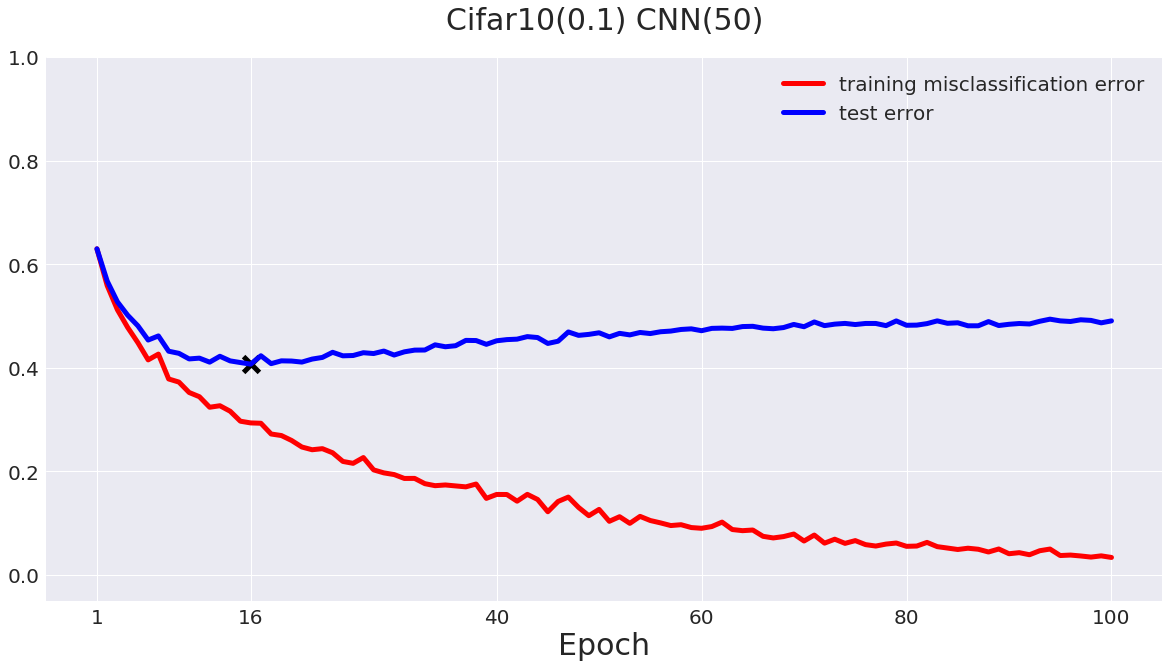

In [41]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Cifar10(0.1) CNN(50)',fontsize=30, y=1.04)

ax.plot(log_1['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log_1['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
x1=np.argmin(log_1['test_error'])
ax.scatter(x1,log_1['test_error'][x1],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
ax.set_xticks([0,x1,39,59,79,99])
ax.set_xticklabels([1,x1+1,40,60,80,100])
ax.legend(loc='best',fontsize=20)
fig.savefig('./results_p0.1/(re)train_and_test_error_50.png')

plt.show()

## CNN400

In [57]:
# %%
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 20

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log_1 = {
    'num_params': [],
    'model_state':[],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'w0': [],
    'w1': [],
    'w2': [],
    'w3': [],
    'w4': [],
    'w_fc': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
channels = 400
# here use with_bn to control batch normalisation
model = basic_cnn.CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_1['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 5780810


In [58]:
model, log_1 = train_model(
    model, criterion, optimizer, log_1, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 1.4187 rLoss: 10317304.1900 Error: 0.4590 RampLoss: 0.458960 MarginError: 0.4590 Margin: -8.5620 Lip: 4.9253e-08
test Loss: 1.4884 rLoss: 11515313.4600 Error: 0.4941 RampLoss: 0.494100 MarginError: 0.4941 Margin: -7.9185 Lip: 4.9253e-08
Saving..
Epoch 2/100
----------
train1 Loss: 1.1949 rLoss: 7996827.6505 Error: 0.3681 RampLoss: 0.368140 MarginError: 0.3681 Margin: -7.8970 Lip: 6.0319e-08
test Loss: 1.3576 rLoss: 10243866.5750 Error: 0.4339 RampLoss: 0.433900 MarginError: 0.4339 Margin: -9.0290 Lip: 6.0319e-08
Epoch 3/100
----------
train1 Loss: 1.0273 rLoss: 6318036.3990 Error: 0.3108 RampLoss: 0.310800 MarginError: 0.3108 Margin: -8.4479 Lip: 7.3206e-08
test Loss: 1.3074 rLoss: 9628070.7400 Error: 0.4082 RampLoss: 0.408200 MarginError: 0.4082 Margin: -10.7082 Lip: 7.3206e-08
Epoch 4/100
----------
train1 Loss: 0.8576 rLoss: 4937030.6267 Error: 0.2504 RampLoss: 0.250440 MarginError: 0.2504 Margin: -8.5233 Lip: 7.6954e-08
test Loss: 1.2911 rLoss: 9

In [60]:
import pickle
pickle.dump(log_1,open('./results_p0.1/log_p0.1_400_with_state.log','wb'))

In [69]:
import pickle
log_1=pickle.load(open('./results_p0.1/log_p0.1_400_with_state.log','rb'))

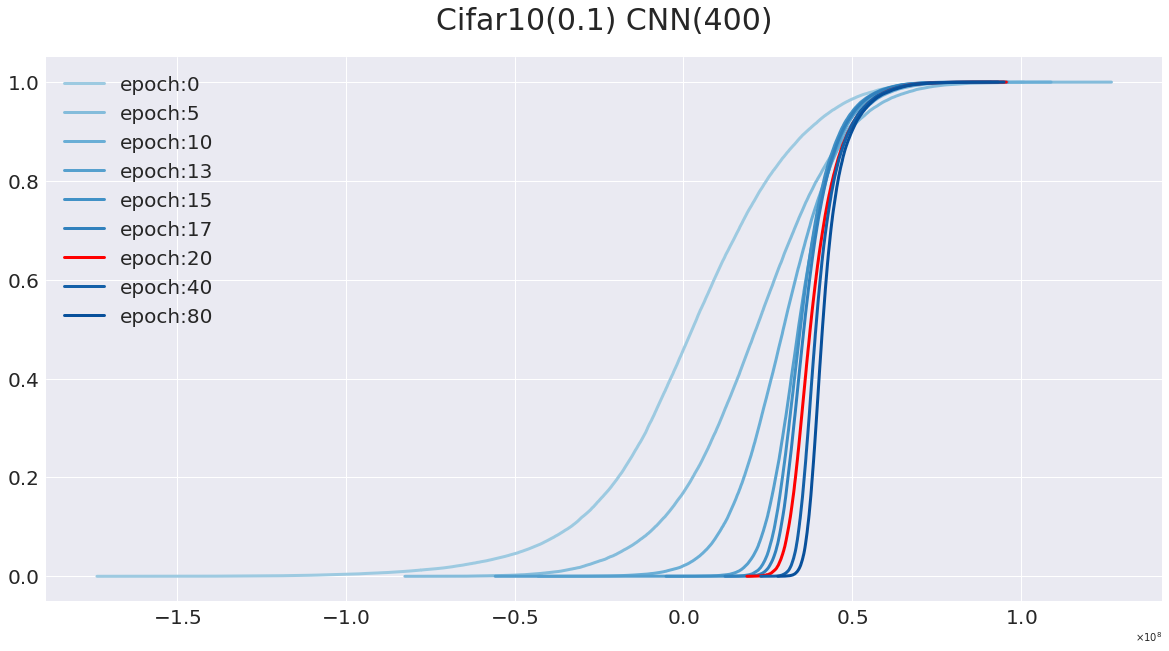

In [62]:
import seaborn as sbn
interval=[-1,1]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('Cifar10(0.1) CNN(400)', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0,5,10,13,15,17,20, 40, 80]):
    c=sbn.color_palette('Blues',15)[j+5]
    if i==20:
        c='r'
    ax.plot(np.sort(log_1['margin_train'][i])/log_1['Lip'][i], np.arange(50000)/50000,label=f'epoch:{i}',c=c,linewidth=3)
#ax.set_xlim(interval)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
ax.legend(fontsize=20)
fig.savefig('./results_p0.1/(re)train_nMargin_distribution_400.png')
plt.show()

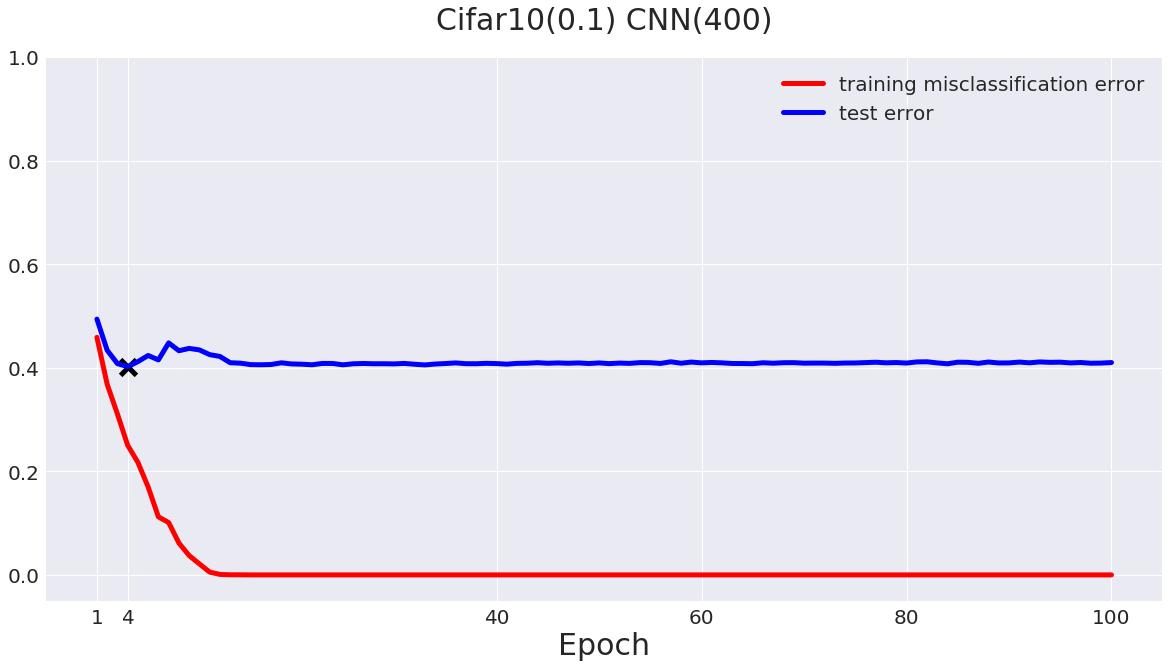

In [71]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Cifar10(0.1) CNN(400)',fontsize=30, y=1.04)

ax.plot(log_1['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log_1['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
x1=np.argmin(log_1['test_error'])
ax.scatter(x1,log_1['test_error'][x1],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
ax.set_xticks([0,x1,39,59,79,99])
ax.set_xticklabels([1,x1+1,40,60,80,100])
ax.legend(loc='best',fontsize=20)
fig.savefig('./results_p0.1/(re)train_and_test_error_400.png')

plt.show()